In [1]:
using JuMP, Ipopt
using CSV, DataFrames, DataStructures, MathOptFormat
using Statistics,Distributions, StatsFuns, StatsBase
using PyPlot
using Random

In [2]:
include("LRO.jl")
include("utils.jl")
include("non_DRO_methods.jl")

SAA (generic function with 1 method)

In [3]:
# normdata.csv is author provided data
df = CSV.read("normdata.csv", DataFrame,header=false)

#sanity check on output of LRO
LRO_opt(df,0,false)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

 x*: 55.95083276342672


55.95083276342672

In [4]:
#sanity check on x* (stocking quantity) as we vary the size of the ambiguity set
x_opt_values = Vector{Float64}()

gamma_vals = -50:1:50

for gamma in gamma_vals 
    x_opt = LRO_opt(df,gamma,false)
    append!(x_opt_values,x_opt)
end 

# print("x opt vals", x_opt_values)

 x*: 58.01689875663777
 x*: 58.0000022293614
 x*: 58.00000049066712
 x*: 57.99999987139498
 x*: 57.999998251608375
 x*: 57.99976214384716
 x*: 57.880950519074446
 x*: 57.75990262024067
 x*: 57.63831465387687
 x*: 57.5161792059793
 x*: 57.393487161316884
 x*: 57.270230440809215
 x*: 57.14639999426333
 x*: 57.02199736168808
 x*: 57.00000277045245
 x*: 57.00000107055469
 x*: 57.000000212950994
 x*: 57.000000122773855
 x*: 57.00000006278711
 x*: 57.00000001467906
 x*: 56.999999969168535
 x*: 56.99999991857461
 x*: 56.99999985192813
 x*: 56.99999929569575
 x*: 56.99999864655151
 x*: 56.99999836746128
 x*: 56.938393264153966
 x*: 56.81421172685681
 x*: 56.68936752233782
 x*: 56.56384887377494
 x*: 56.43764158404479
 x*: 56.31073016247865
 x*: 56.1830999197613
 x*: 56.05473645439377
 x*: 56.00000673962221
 x*: 56.000001313320894
 x*: 56.00000072888994
 x*: 56.00000016800507
 x*: 56.000000110783446
 x*: 56.00000007097841
 x*: 56.0000000398208
 x*: 56.000000012841085
 x*: 55.99999998717004
 x*:

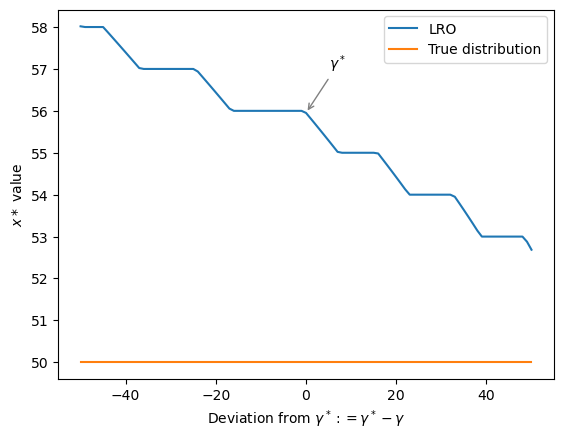

In [5]:
# rc("text", usetex=true)

#graph sanity check
ones(size(gamma_vals))*50

plot(gamma_vals, x_opt_values,label="LRO")
plot(gamma_vals, ones(size(gamma_vals)) * 50,label="True Distribution")
# print(x_opt_values)
# title("Function of Gamma")
xlabel( L"Deviation from $\gamma^*:= \gamma^* - \gamma$ ")
ylabel(L"$x*$ value")
legend()

dx = maximum(gamma_vals) - minimum(gamma_vals)
dy = maximum(x_opt_values) - minimum(x_opt_values)

#graph arrow to point out \gamma^*
annotate(L"$\gamma^*$ ",
xy=[gamma_vals[51];x_opt_values[51]],
xytext=[gamma_vals[51]+0.05dx;x_opt_values[51]+0.2dy],
xycoords="data",
arrowprops=Dict("arrowstyle"=>"->","color"=>"gray")) # Julia dictionary objects are automatically converted to Python object when they pass into a PyPlot function

savefig("gamma_results.pdf")

In [6]:
# sanity check on LRO with moment information

LRO_opt(df,0,true)

 x*: 52.00009108316197


52.00009108316197

In [7]:
#sanity check on scarf

scarf(df)

53.016

In [9]:
#sanity check on SAA

SAA(df)

x = 48.99999661256657


48.99999661256657

In [10]:
# sanity check on true distribution

critical_fractile()

(50.0, '\n')

In [19]:
# calculate x* as function of sample size of simulated data (not data used in paper)

#vectors to store final values
LRO_values_tot_norm = Vector{Vector{Float64}}()
LRO_moment_values_tot_norm = Vector{Vector{Float64}}()
scarf_values_tot_norm  = Vector{Vector{Float64}}()
SAA_values_tot_norm  = Vector{Vector{Float64}}()

for iter in 1:10
    Random.seed!(iter)
    
    dist_size = 3000 # maximum number of samples
    
    dist = Normal(50,50)
    
    samp = rand(dist,dist_size)
    samp = trunc.(Int,samp)

    for i in 1:length(samp)  # truncate values between [0,200] (as done in the paper)
        val = samp[i]
        while val < 0 || val > 200
            val = trunc.(Int,rand(dist))
        end
        samp[i] = val
    end

    df_sim = DataFrame()

    df_sim.Column1 = samp

    LRO_values = Vector{Float64}()
    LRO_moment_values = Vector{Float64}()
    scarf_values = Vector{Float64}()
    SAA_values = Vector{Float64}()

    for i in 250:150:dist_size  #vary sample size from [250,3000] by 150 each iteration
        df_samp = df_sim[shuffle(1:nrow(df_sim))[1:i], :]

        lro = LRO_opt(df_samp,0,false)
        append!(LRO_values, lro)

        lro_moment = LRO_opt(df_samp,0,true)
        append!(LRO_moment_values, lro_moment)

        scarf_val = scarf(df_samp)
        append!(scarf_values, scarf_val)

        saa = SAA(df_samp)
        append!(SAA_values, saa)
    end

    append!(LRO_values_tot_norm , [LRO_values])
    append!(LRO_moment_values_tot_norm , [LRO_moment_values])
    append!(scarf_values_tot_norm , [scarf_values])
    append!(SAA_values_tot_norm , [SAA_values])
end

 x*: 78.99999985406808
 x*: 68.16547635206203
x = 65.99999905744386
 x*: 72.0000001963655
 x*: 64.21992927976187
x = 61.30635596503608
 x*: 70.27010929566092
 x*: 65.31132735710875
x = 62.33933876389391
 x*: 69.67619032961862
 x*: 65.00018401387345
x = 63.00000476542488
 x*: 65.99999985334149
 x*: 62.34953323212552
x = 59.999996011622365
 x*: 66.00000577432253
 x*: 63.70395757084479
x = 62.00000055614581
 x*: 64.0000017765546
 x*: 62.00029230057917
x = 60.99998572477937
 x*: 64.00000215030144
 x*: 62.000078038456685
x = 59.99999885668593
 x*: 64.37975757229397
 x*: 62.27121967952682
x = 60.999980183354054
 x*: 64.04402154024396
 x*: 62.99998822888159
x = 60.99999639327327
 x*: 64.00000029439764
 x*: 62.16554129047786
x = 59.99999945584018
 x*: 64.00000012531979
 x*: 62.0226856677613
x = 60.99997402758367
 x*: 64.00000003280984
 x*: 62.68744670433294
x = 60.9999797769528
 x*: 63.990213736231986
 x*: 62.000122135075046
x = 60.000007344189434
 x*: 63.639028832277624
 x*: 62.07986027891788

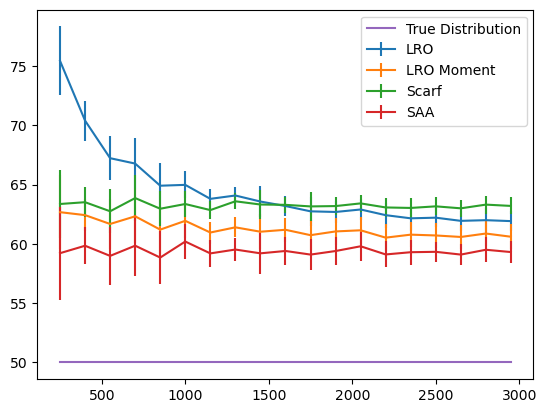

PyObject <matplotlib.legend.Legend object at 0x00000000623CF370>

In [24]:
# max number of samples
dist_size = 3000

#plot error bars for methods
errorbar(250:150:dist_size, mean(LRO_values_tot_norm ), std(LRO_values_tot_norm), label="LRO")
errorbar(250:150:dist_size, mean(LRO_moment_values_tot_norm ),std(LRO_moment_values_tot_norm), label="LRO Moment")
errorbar(250:150:dist_size, mean(scarf_values_tot_norm ),std(scarf_values_tot_norm), label="Scarf")
errorbar(250:150:dist_size, mean(SAA_values_tot_norm ),std(SAA_values_tot_norm), label="SAA")

plot(250:150:dist_size, ones(length(250:150:dist_size)) * 50, label="True Distribution")

legend()

In [21]:
# calculate x* as function of sample size of simulated data (not data used in paper)

#vectors to store final values
LRO_values_tot_exp = Vector{Vector{Float64}}()
LRO_moment_values_tot_exp = Vector{Vector{Float64}}()
scarf_values_tot_exp = Vector{Vector{Float64}}()
SAA_values_tot_exp = Vector{Vector{Float64}}()

for iter in 1:10
    Random.seed!(iter)
    
    dist_size = 3000 #maximum number of samples
    
    dist = Exponential(50)
    
    samp = rand(dist,dist_size)
    samp = trunc.(Int,samp)
    
    for i in 1:length(samp)
        val = samp[i]
        while val < 0 || val > 200 #truncate values between [0,200] (as done in paper)
            val = trunc.(Int,rand(dist))
        end
        samp[i] = val
    end

    df_sim = DataFrame()

    df_sim.Column1 =samp

    LRO_values = Vector{Float64}()
    LRO_moment_values = Vector{Float64}()
    scarf_values = Vector{Float64}()
    SAA_values = Vector{Float64}()

    for i in 250:150:dist_size #vary sample size from [250,3000] by 150 each iteration
        df_samp = df_sim[shuffle(1:nrow(df_sim))[1:i], :]

        lro = LRO_opt(df_samp,0,false)
        append!(LRO_values, lro)

        lro_moment = LRO_opt(df_samp,0,true)
        append!(LRO_moment_values, lro_moment)

        scarf_val = scarf(df_samp)
        append!(scarf_values, scarf_val)

        saa = SAA(df_samp)
        append!(SAA_values, saa)
    end

    append!(LRO_values_tot_exp, [LRO_values])
    append!(LRO_moment_values_tot_exp, [LRO_moment_values])
    append!(scarf_values_tot_exp, [scarf_values])
    append!(SAA_values_tot_exp, [SAA_values])
end

 x*: 53.000000684745764
 x*: 29.000119875073526
x = 29.99999985883761
 x*: 47.00000072485543
 x*: 31.000004649251863
x = 31.182533559126004
 x*: 48.00000134709908
 x*: 34.96088774552294
x = 34.99999994016384
 x*: 43.00000089829025
 x*: 30.999987731470874
x = 31.999993955030675
 x*: 45.00000112376718
 x*: 34.45343671708441
x = 34.00000165284485
 x*: 41.008735022045116
 x*: 31.00001144832539
x = 31.999999464331374
 x*: 44.000000328300914
 x*: 34.99997156540452
x = 34.99999983789745
 x*: 42.99998912538389
 x*: 33.999935342232625
x = 33.99999985976114
 x*: 42.00000040622541
 x*: 33.999998846433364
x = 33.999992807995675
 x*: 41.999991521199085
 x*: 33.99994554875589
x = 33.99999917842264
 x*: 41.000000375173634
 x*: 33.9999501570057
x = 33.999996264674486
 x*: 40.02833980134347
 x*: 33.14100568263236
x = 33.99999783764875
 x*: 41.99999890978626
 x*: 34.99998986419849
x = 35.00000054366543
 x*: 39.999998131388665
 x*: 33.849156090360495
x = 33.99999889148338
 x*: 40.73250991060875
 x*: 34.0

In [15]:
#critical fractile formula"


# plugged and chugged with cdf of exponential function to get warm start value (solver kept converging to point of infeasibility)
# cdf_func(x) = cdf(Exponential(50),x)
# print(cdf_func(34.65))

model3 = Model(with_optimizer(Ipopt.Optimizer))

@variable(model3, x_var, start=34) #use warm start to avoid converge to infeasible point (see above)

b = 1
h = 1

JuMP.register(model3, :cdf_func, 1, cdf_func; autodiff = true)  #to use cdf function in constraint

@NLconstraint(model3,con1, cdf_func(x_var) >= b/(b+h))
# # print("hey")

@objective(model3,Min,x_var)
optimize!(model3)

println("x = ", value(x_var))

critical fractile formula
This is Ipopt version 3.13.2, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        1
Number of nonzeros in Lagrangian Hessian.............:        1

Total number of variables............................:        1
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) al

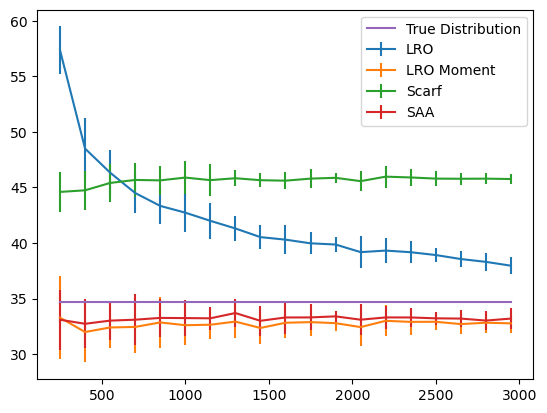

PyObject <matplotlib.legend.Legend object at 0x00000000624353D0>

In [25]:
# max number of samples
dist_size = 3000

#plot error bar for methods
errorbar(250:150:dist_size, mean(LRO_values_tot_exp), std(LRO_values_tot_exp), label="LRO")
errorbar(250:150:dist_size, mean(LRO_moment_values_tot_exp),std(LRO_moment_values_tot_exp),label="LRO Moment")
errorbar(250:150:dist_size, mean(scarf_values_tot_exp),std(scarf_values_tot_exp),label="Scarf")
errorbar(250:150:dist_size, mean(SAA_values_tot_exp),std(SAA_values_tot_exp),label="SAA")

plot(250:150:dist_size, ones(length(250:150:dist_size)) * 34.65735803050322 ,label="True Distribution")

legend()

In [32]:
#TODO: costs when distribution comes from D(\gamma)

model = Model(with_optimizer(Ipopt.Optimizer,print_level=0))

N_i = get_occurences(df) 
N = sum(N_i[:,"Occurence"])

gamma = get_gamma_val(N_i, N)

@variable(model, lambda_var >=0)
@variable(model, 56<=x_var<=56)
@variable(model, y_vars[1:length(N_i[:,"Occurence"])] >=0)

@variable(model, mu_var)

b = 1
h = 1

z = sum(N_i[:,"Occurence"] .* log.(N_i[:,"Occurence"]))

var_len = length(N_i[:,"Occurence"])

@constraint(model,con1[i = 1:var_len], b * (N_i[:,"Demand"][i] - x_var) + y_vars[i] <= mu_var)
@constraint(model, con2[i = 1:var_len], h * (x_var - N_i[:,"Demand"][i]) + y_vars[i] <= mu_var)

@NLobjective(model, Min, mu_var + lambda_var * (z - N - gamma) + N * lambda_var * log(lambda_var)
 - lambda_var * sum(N_i[:,"Occurence"][j] * log(y_vars[j]) for j in 1:var_len))

write_LP(model,"model")

optimize!(model)

# println(" x*: ", value(x_var))
print(objective_value(model))


 x*: 56.0
47.7599685702873